**Author**: Andy Tzanidakis \
Last updated: May 07, 2024

## Overview



- Learn how to use VizieR TAP query to access tables and store/handle them in `LSDB`
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Pass HipsCat LSDB catalogs to `TAPE` to perform time-series analysis and exploration


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 2

import lsdb
from lsdb.core.search import ConeSearch
import tape
from tape import Ensemble, ColumnMapper

import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'}) # store dask temporary files on SSD...
dask.config.set({"dataframe.shuffle-compression": 'Snappy'}) # snappy algorithm for shuffle compression

from dask.distributed import Client

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [2]:
lsdb.__version__

'0.2.3.dev6+gb532108'

## VizieR Querying

In [3]:
## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

In [4]:
# the catalogue name in VizieR (Gaia DR3 part 6)
CATALOGUE = "I/360"

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

In [5]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [6]:
print (f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


In [7]:
# Let's read quickly the table description...
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capabilty service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Subjects: I/360
Waveband Coverage: optical
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


In [8]:
# Select the first table name
table_name_1 = "I/360/goldf"
first_table_name = table_name_1

In [9]:
# Initialize tap service
tap_service = voresource.get_service("tap")
# Run a query to get the first 2000000 rows given a sky constraint (40x40 deg)
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{first_table_name}" WHERE (DE_ICRS BETWEEN 0 and 40) AND (RA_ICRS BETWEEN 80 and 120)')

In [10]:
# Obtain table from TAP query
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

In [11]:
print (f"Number of sources: {len(table_df)}")

Number of sources: 146151


Text(0, 0.5, 'DEC [deg]')

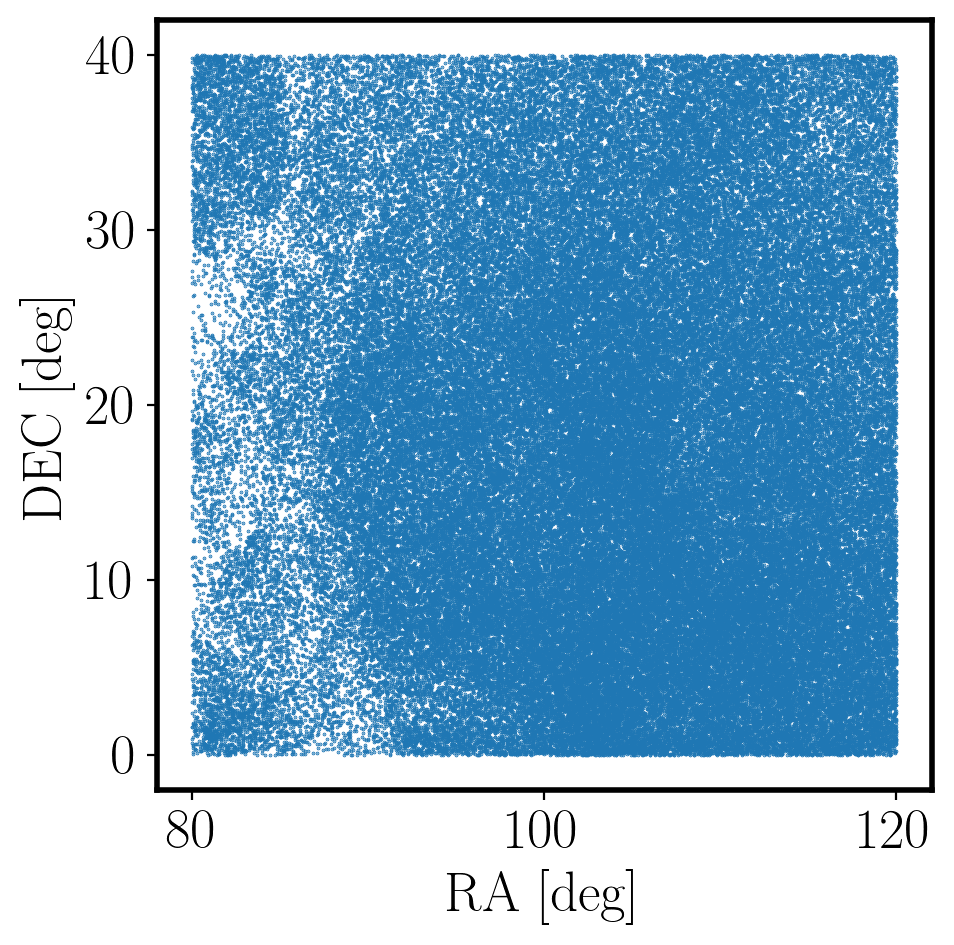

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(table_df['RA_ICRS'], table_df['DE_ICRS'], s=0.1)

plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

In [13]:
# select only M-type stars
table_df = table_df[table_df['SpType'].str.contains('M')]

In [14]:
# inspect first row
table_df.head(1)

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
96,1302564,3414418568469105024,3537.0732,4.8277,-0.4692,1.0736,0.6528,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,M,80.069883,21.728261,80.069883,21.728261


In [15]:
print (f"Number of M-type stars: {len(table_df)}")

Number of M-type stars: 1304


In [16]:
# initialize dask client
client = Client(n_workers=6, threads_per_worker=1, memory_limit='auto')

In [ ]:
client

In [ ]:
# shape of final data
np.shape(table_df)

In [32]:
%%time

# Hipsccat VizieR table
hips_object = lsdb.from_dataframe(
    table_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS",
    lowest_order=5)

In [ ]:
hips_object

In [ ]:
from hipscat.inspection import plot_pixels
plot_pixels(hips_object.hc_structure)

In [ ]:
%%time
hips_object.head(1)

## Load Additional Catalogs

In [ ]:
# load ZTF source table
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource",
                                 search_filter=ConeSearch(ra=27.5, dec=27.5, radius_arcsec=27.5*3600))

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14",
                        columns=['ps1_objid', 'nobs_r', 'nobs_g', 'ra', 'dec'],
                          search_filter=ConeSearch(ra=27.5, dec=27.5, radius_arcsec=27.5*3600)) # select only Nobs (gr) bands

In [ ]:
ztf

## Crossmatch

In [ ]:
xmatch_golden_ztf_object = hips_object.crossmatch(ztf, 
                                                  n_neighbors=1, radius_arcsec=1, require_right_margin=False)

In [ ]:
xmatch_golden_ztf_object

In [ ]:
xmatch_golden_ztf_object.head(1)

In [ ]:
#%%time
# Head of xmatch table with 250k rows for exploration
#xmatch_golden_ztf_object_comp = xmatch_golden_ztf_object.compute()

In [ ]:
%%time
hips_object_v2 = lsdb.from_dataframe(
    xmatch_golden_ztf_object_comp,
    catalog_name="golden",
    catalog_type="object",
    ra_column="ra_ztf_dr14", 
    dec_column="dec_ztf_dr14")

In [ ]:
xmatch_golden_ztf_object_comp.keys()

In [ ]:
plt.figure(figsize=(4, 5))
plt.scatter(xmatch_golden_ztf_object_comp['Teff-P_golden'],
             np.log(xmatch_golden_ztf_object_comp['Lum-F_golden']), s=1, 
             color='#28282B')
plt.xlim(plt.xlim(3200, 4700)[::-1])
plt.ylim(-6, -1)
plt.minorticks_on()
plt.xlabel(r"$T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L/L_\odot$")


In [ ]:
%%time
# sync source catalog data to object (xmatched) object
_sources = xmatch_golden_ztf_object.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

## TAPE

In [ ]:
# Initialize an Ensemble
ens = Ensemble(client=client)
ens.client_info()

In [ ]:
_sources

In [ ]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_zource',
        flux_col='mag_ztf_zource',
        err_col='magerr_ztf_zource',
        band_col='band_ztf_zource',
      )


ens.from_lsdb(
    source_catalog=_sources,
    object_catalog=xmatch_golden_ztf_object,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

In [ ]:
ens.source

In [ ]:
ts = ens.to_timeseries(9049076108623872)

In [ ]:
rband = ts.data[ts.band=='r']

plt.figure(figsize=(10, 6))
plt.errorbar(rband.mjd_ztf_zource, rband.mag_ztf_zource, yerr=rband.magerr_ztf_zource, color='r', fmt='.', capsize=2)
plt.ylim(plt.ylim()[::-1])



## Calculating Time-Series Features

In [ ]:
!pip install cesium

In [ ]:
from cesium import featurize

In [ ]:
features_to_use = ['amplitude',
                'percent_beyond_1_std',
                'maximum',
                'median',
                'median_absolute_deviation',
                'percent_close_to_median',
                'minimum',
                'skew',
                'std',
                'weighted_average', 
                "flux_percentile_ratio_mid20", 
                "flux_percentile_ratio_mid35",
                "flux_percentile_ratio_mid50",
                "flux_percentile_ratio_mid65",
                "flux_percentile_ratio_mid80",
                "stetson_j",
                  "stetson_k"]

In [ ]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    # Compute features
    summary_ = {}

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 



In [ ]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=features_to_use, dtype=float)

In [ ]:
_sources

In [ ]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    compute_features,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

In [ ]:
%%time
#ens.object.join(calc_).update_ensemble()

In [ ]:
client

In [ ]:
dask.config.set({"dataframe.convert-string": False})

In [ ]:
%%time
obj_features = calc_.compute()